# Heart Disease Prediction with XGBoost
Pipeline: EDA → preprocessing → tuning XGBoost → ewaluacja → interpretowalność (SHAP).

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, balanced_accuracy_score
)

from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Podział na cechy i target
`HeartDisease` = 1 oznacza obecność choroby serca.

In [4]:
y = df["HeartDisease"]
X = df.drop(columns=["HeartDisease"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

## Model + tuning hiperparametrów (RandomizedSearchCV)

In [5]:
model = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

clf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])

param_grid = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [3, 4, 5, 6],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__reg_alpha": [0, 0.1, 1.0],
    "model__reg_lambda": [1.0, 10.0, 100.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    clf,
    param_distributions=param_grid,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

search.best_params_, search.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


({'model__subsample': 0.6,
  'model__reg_lambda': 1.0,
  'model__reg_alpha': 1.0,
  'model__n_estimators': 100,
  'model__max_depth': 6,
  'model__learning_rate': 0.01,
  'model__colsample_bytree': 0.8},
 np.float64(0.9201017356407044))

## Ewaluacja na zbiorze testowym

In [6]:
pred = best_model.predict(X_test)
proba = best_model.predict_proba(X_test)[:, 1]

print("Balanced accuracy:", balanced_accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, proba))
print("PR AUC:", average_precision_score(y_test, proba))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

Balanced accuracy: 0.8827514745735693
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       123
           1       0.88      0.93      0.90       153

    accuracy                           0.89       276
   macro avg       0.89      0.88      0.89       276
weighted avg       0.89      0.89      0.89       276

ROC AUC: 0.9327541314628833
PR AUC: 0.927533905414865
Confusion matrix:
 [[103  20]
 [ 11 142]]


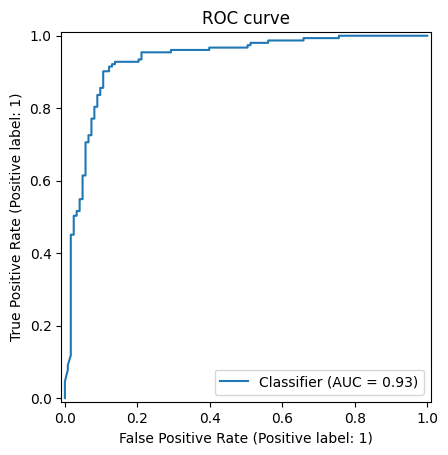

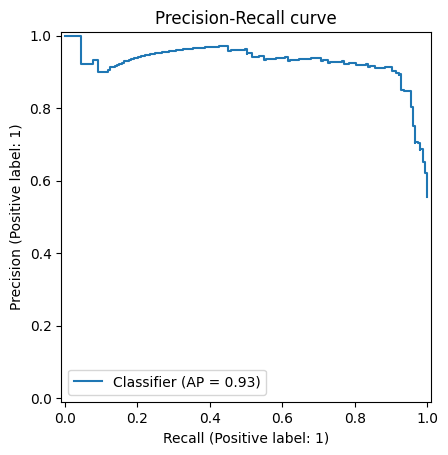

In [7]:
RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title("Precision-Recall curve")
plt.show()

## Interpretowalność (SHAP)

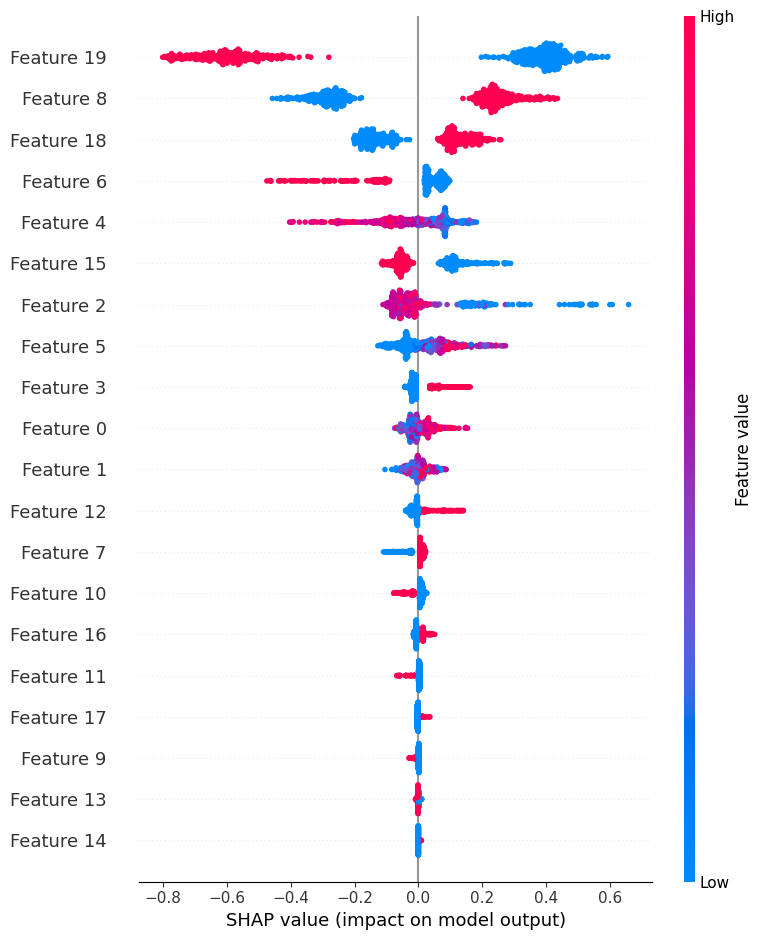

In [8]:
import shap

X_train_transformed = best_model.named_steps["preprocessor"].transform(X_train)
explainer = shap.TreeExplainer(best_model.named_steps["model"])
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, show=True)